# Final project with multiple features


## Prepare Data

In [1]:
!pip install meteostat


[notice] A new release of pip is available: 23.1.1 -> 23.1.2
[notice] To update, run: python -m pip install --upgrade pip


In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import datetime
import pandas as pd
from sklearn.preprocessing import StandardScaler
from meteostat import Point, Daily, Hourly, Stations
import torch



In [3]:

lat = 47.6
lon = -122.3

# Define start and end times
start = datetime.datetime(2012, 1, 1)
end = datetime.datetime(2022, 1, 1)

data = Hourly(Point(lat,lon), start=start, end=end).fetch()

# Find how much data we have
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 87673 entries, 2012-01-01 00:00:00 to 2022-01-01 00:00:00
Freq: H
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   temp    87673 non-null  float64
 1   dwpt    87673 non-null  float64
 2   rhum    87673 non-null  float64
 3   prcp    87098 non-null  float64
 4   snow    0 non-null      float64
 5   wdir    86382 non-null  float64
 6   wspd    87673 non-null  float64
 7   wpgt    0 non-null      float64
 8   pres    87672 non-null  float64
 9   tsun    0 non-null      float64
 10  coco    34425 non-null  float64
dtypes: float64(11)
memory usage: 8.0 MB


In [4]:
# Extract all relevant channels and impute and missing values
data_cleaned = data[['temp', 'dwpt', 'prcp', 'wspd', 'wdir', 'pres']]
print(data_cleaned.isna().any())

# Replace NaN values with 0 for 'prcp' feature
data_cleaned['prcp'].fillna(0, inplace=True)

# Use linear interpolation for other features
data_cleaned['temp'].interpolate(method='linear', inplace=True)
data_cleaned['dwpt'].interpolate(method='linear', inplace=True)
data_cleaned['wspd'].interpolate(method='linear', inplace=True)
data_cleaned['wdir'].interpolate(method='linear', inplace=True)
data_cleaned['pres'].interpolate(method='linear', inplace=True)

print(data_cleaned.isna().any())


temp    False
dwpt    False
prcp     True
wspd    False
wdir     True
pres     True
dtype: bool
temp    False
dwpt    False
prcp    False
wspd    False
wdir    False
pres    False
dtype: bool


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [5]:
def transform_datetime_index(dates):
    transformed_dates = []

    for date_str in dates:
        hour = date_str.hour
        day = date_str.day
        month = date_str.month
        year = date_str.year
        transformed_dates.append([hour, day, month, year])

    return transformed_dates

def combine_arrays(A1, A2):
    if len(A1)==len(A2):
        A = []
        for i in range(len(A1)):
            combined_element = np.append(A1[i], A2[i])
            A.append(combined_element)
        return A
    elif len(A1)!=len(A2):
        print('Different dates lenght than data')
        print(len(A1)-len(A2))

dates=data_cleaned.index
transformed_dates = np.array(transform_datetime_index(dates)).astype('float32')


In [6]:
timeseries = data_cleaned.values.astype('float32')

mea=np.mean(timeseries[:,0])
sig=np.std(timeseries[:,0])

scaler = StandardScaler()

scaler.fit(timeseries)

timeseries=scaler.transform(timeseries)

#With this next line (executed) we can include time into the timeseries
#timeseries=np.squeeze(combine_arrays(timeseries,transformed_dates)).astype('float32')

# train-test split for time series
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

num_features=timeseries.shape[1]

num_features

6

In [7]:
def create_dataset(dataset, lookback):
    X, y = [], []
    for i in range(len(dataset) - lookback):
        features = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(features)
        y.append(target)
    return torch.tensor(X), torch.tensor(y)

## Create model

In [8]:
lookback = 24
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)


In [9]:
class TempModel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.lstm1 = torch.nn.LSTM(input_size=num_features, hidden_size=50, num_layers=1, batch_first=True)
        self.linear = torch.nn.Linear(50, num_features)
        self.lstm2 = torch.nn.LSTM(25, num_features)
        
    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.linear(x)
        return x

In [10]:
model = TempModel()
optimizer = torch.optim.Adam(model.parameters())
loss_fn = torch.nn.MSELoss()
loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), shuffle=True, batch_size=512)
n_epochs = 10


## Train

In [11]:
for epoch in range(n_epochs):
    model.train()
    for X_batch, y_batch in loader:
        y_pred = model(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred = model(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = model(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


Epoch 0: train RMSE 0.5861, test RMSE 0.6202
Epoch 1: train RMSE 0.5361, test RMSE 0.5746
Epoch 2: train RMSE 0.5258, test RMSE 0.5670
Epoch 3: train RMSE 0.5201, test RMSE 0.5635
Epoch 4: train RMSE 0.5164, test RMSE 0.5616
Epoch 5: train RMSE 0.5135, test RMSE 0.5597
Epoch 6: train RMSE 0.5113, test RMSE 0.5585
Epoch 7: train RMSE 0.5098, test RMSE 0.5613
Epoch 8: train RMSE 0.5081, test RMSE 0.5597
Epoch 9: train RMSE 0.5066, test RMSE 0.5602


## Evaluate

In [12]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = model(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = model(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = model(X_test)[:, -1, :]

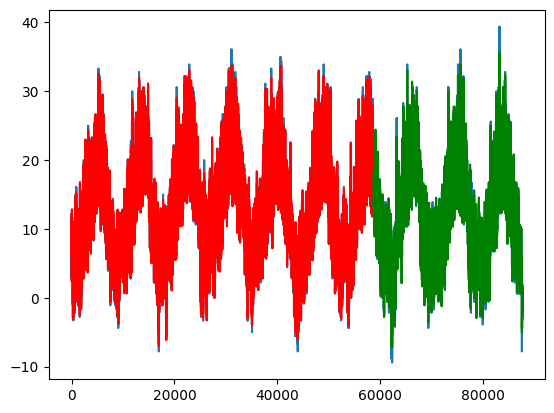

In [13]:
# plot
plt.plot(timeseries[:,0]*sig+mea)
plt.plot(train_plot[:,0]*sig+mea, c='r')
plt.plot(test_plot[:,0]*sig+mea, c='g')
plt.show()

## Predicting n values

In [14]:
n=24
with torch.no_grad():
    x_test=timeseries[-(lookback+1):-1]
    xt_test=torch.from_numpy(x_test)
    prediction=model(xt_test)
    totalarray=torch.zeros(lookback+n,num_features)

    totalarray[0:lookback]=xt_test

    for i in range(n):

        froz = int((totalarray == 0).all(dim=1).nonzero(as_tuple=False)[0])

        next_value=model(totalarray[int(froz-lookback):int(froz)])

        totalarray[froz]=next_value[0]

test_price=totalarray[0:lookback,0].detach().numpy()

price_prediction=totalarray[lookback:-1,0].detach().numpy()

middle=np.array([test_price[-1],price_prediction[0]])


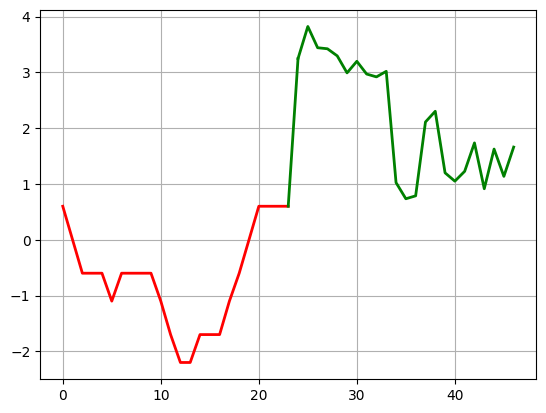

In [15]:
plt.plot((test_price)*sig+mea, c='r', linewidth=2)
plt.plot(range(lookback-1, lookback + len(middle)-1), (middle)*sig+mea, color='g', linewidth=2)
plt.plot(range(lookback, lookback + len(price_prediction)), (price_prediction)*sig+mea, color='g', linewidth=2)
plt.grid()

In [ ]:
n=24
with torch.no_grad():
    x_test=timeseries[-(lookback+1)*2:-(lookback+2)]
    xt_test=torch.from_numpy(x_test)
    prediction=model(xt_test)
    totalarray=torch.zeros(lookback+n,num_features)

    totalarray[0:lookback]=xt_test

    for i in range(n):

        froz = int((totalarray == 0).all(dim=1).nonzero(as_tuple=False)[0])

        next_value=model(totalarray[int(froz-lookback):int(froz)])

        totalarray[froz]=next_value[0]

test_price=totalarray[0:lookback,0].detach().numpy()

price_prediction=totalarray[lookback:-1,0].detach().numpy()

middle=np.array([test_price[-1],price_prediction[0]])


In [ ]:
plt.plot((test_price)*sig+mea, c='r', linewidth=3)
plt.plot(range(lookback-1, lookback + len(middle)-1), (middle)*sig+mea, color='g', linewidth=3)
plt.plot(range(lookback, lookback + len(price_prediction)), (price_prediction)*sig+mea, color='g', linewidth=3)
plt.plot(mea+sig*timeseries[:,0][-(lookback+1)*2:-1], linewidth=1)
plt.grid()